In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)

sys.path.append("../..")

from drift_detector.explainer import ShiftExplainer
from drift_detector.experiments import *
from utils.constants import *
from utils.plot_utils import errorfill, plot_roc, plot_pr, linestyles, markers, colors, brightness, colorscale
from utils.utils import *
from baseline_models.static.utils import run_model

2022-07-18 14:34:12,159 INFO cyclops.orm     - Database setup, ready to run queries!


### Define Parameters ###

In [14]:
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000]
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
CALC_ACC = True
TIMESTEPS = 6
AGGREGATION_TYPE = "time"
SCALE=True
CONTEXT_TYPE="lstm"
MODEL_PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/random/random_lstm.pt"
REPRESENTATION="rf"
DR_TECHNIQUES = ["NoRed"]#["NoRed","SRP", "PCA", "kPCA", "Isomap","BBSDs_untrained_FFNN","BBSDs_untrained_LSTM", "BBSDs_trained_LSTM"]
MD_TESTS = ["Context-Aware MMD"]#["LSDD", "MMD", "LK","Classifier","Context-Aware MMD"]
HOSPITAL = ["SMH","MSH","THPC","THPM","UHNTG","UHNTW","PMH"]

# Query Data

In [11]:
admin_data, x, y = get_gemini_data(PATH)

2022-07-18 14:39:13,889 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-07-18 14:39:14,205 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-07-18 14:39:14,290 INFO cyclops.feature_handler - Loading features from file...
2022-07-18 14:39:14,292 INFO cyclops.feature_handler - Found file to load for static features...
2022-07-18 14:39:14,295 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-07-18 14:39:14,402 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-07-18 14:39:19,230 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-07-18 14:39:27,853 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


In [12]:
SHIFT = input("Select shift experiment: ")
OUTCOME = input("Select outcome variable: ")

# Define shift types.
if SHIFT =='ko_shift':
    shifts = ['ko_shift_0.1','ko_shift_0.5','ko_shift_1.0']
elif SHIFT == 'small_gn_shift':
    shifts = ['small_gn_shift_0.1','small_gn_shift_0.5','small_gn_shift_1.0']
elif SHIFT == 'medium_gn_shift':
    shifts = ['medium_gn_shift_0.1', 'medium_gn_shift_0.5','medium_gn_shift_1.0']
elif SHIFT == 'large_gn_shift':
    shifts = ['large_gn_shift_0.1','large_gn_shift_0.5','large_gn_shift_1.0']
elif SHIFT == 'mfa_shift':
    shifts = ['mfa_shift_0.25','mfa_shift_0.5','mfa_shift_0.75']
elif SHIFT == 'cp_shift':
    shifts = ['cp_shift_0.25','cp_shift_0.75']
elif SHIFT == 'small_bn_shift':
    shifts = ['small_bn_shift_0.1','small_bn_shift_0.5','small_bn_shift_1.0']
elif SHIFT == 'medium_bn_shift':
    shifts = ['medium_bn_shift_0.1','medium_bn_shift_0.5','medium_bn_shift_1.0']
elif SHIFT == 'large_bn_shift':
    shifts = ['large_bn_shift_0.1','large_bn_shift_0.5','large_bn_shift_1.0']

Select shift experiment:  small_gn_shift
Select outcome variable:  mortality


## Run Shift Experiments ##

In [ ]:
if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "rb") as f:
        mean_shifts_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "rb") as f:
        mean_shifts_dr_md_dist = pickle.load(f)
else:
    mean_shifts_dr_md_pval = np.ones((len(shifts), len(DR_TECHNIQUES),len(MD_TESTS),len(SAMPLES))) * (-1)
    mean_shifts_dr_md_dist = np.ones((len(shifts), len(DR_TECHNIQUES),len(MD_TESTS),len(SAMPLES))) * (-1)

if os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "rb") as f:
        std_shifts_dr_md_pval = pickle.load(f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "rb") as f:
        std_shifts_dr_md_dist = pickle.load(f)
else:
    std_shifts_dr_md_pval = np.ones((len(shifts), len(DR_TECHNIQUES),len(MD_TESTS),len(SAMPLES))) * (-1)
    std_shifts_dr_md_dist = np.ones((len(shifts), len(DR_TECHNIQUES),len(MD_TESTS),len(SAMPLES))) * (-1)

for si, shift in enumerate(shifts):
    for di, dr_technique in enumerate(DR_TECHNIQUES):
        for mi, md_test in enumerate(MD_TESTS):
            if np.any(mean_shifts_dr_md_pval[si, di, mi, :] == -1):
                print(
                            "{} | {} | {} ".format(
                                shift, dr_technique, md_test
                            )
                        )
                try:
                    mean_p_vals, std_p_vals, mean_dist, std_dist = run_synthetic_shift_experiment(
                        shift=shift,
                        admin_data=admin_data,
                        x=x, 
                        y=y,
                        outcome=OUTCOME,
                        hospital=HOSPITAL,
                        path=PATH,
                        aggregation_type=AGGREGATION_TYPE,
                        scale=SCALE,
                        dr_technique=dr_technique,
                        model_path=MODEL_PATH,
                        md_test=md_test,
                        context_type=CONTEXT_TYPE,
                        representation=REPRESENTATION,
                        samples=SAMPLES,
                        dataset=DATASET,
                        sign_level=SIGN_LEVEL,
                        timesteps=TIMESTEPS,
                        random_runs=RANDOM_RUNS,
                        calc_acc=CALC_ACC
                    )
                    mean_shifts_dr_md_pval[si,di,mi,:] = mean_p_vals
                    std_shifts_dr_md_pval[si,di,mi,:] = std_p_vals
                    mean_shifts_dr_md_dist[si,di,mi,:] = mean_dist
                    std_shifts_dr_md_dist[si,di,mi,:] = std_dist

                except ValueError as e:
                    print("Value Error")
                    pass


In [36]:
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(mean_shifts_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"mean_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(mean_shifts_dr_md_dist, f)
if not os.path.exists(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"_mean_dr_md_pval.pkl"]))):
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_pval.pkl"])), "wb") as f:
        pickle.dump(std_shifts_dr_md_pval, f)
    with open(os.path.join(PATH, '_'.join([SHIFT, '_'.join(HOSPITAL),"std_dr_md_dist.pkl"])), "wb") as f:
        pickle.dump(std_shifts_dr_md_dist, f)

Select Pre-Processing:  NoRed
Select Two-Sample Testing:  LSDD


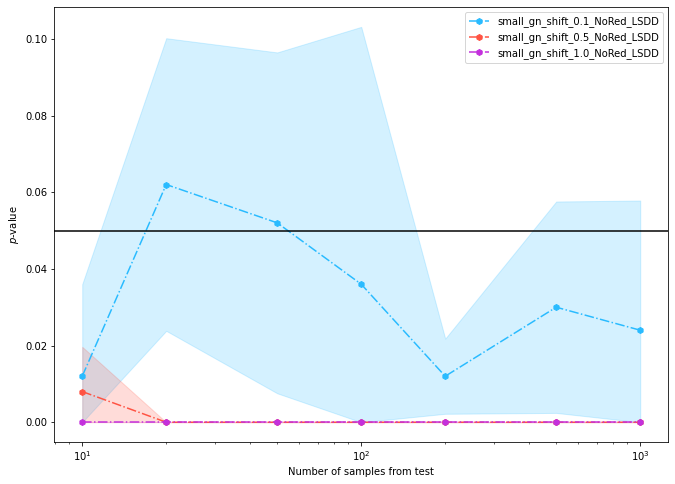

In [37]:
DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")

fig = plt.figure(figsize=(11, 8))
for si, shift in enumerate(shifts):
    for di, dr_technique in enumerate(dr_techniques):
        for mi, md_test in enumerate(md_tests):
            if (
                    dr_technique == DIM_RED
                    and md_test == MD_TEST
            ):
                errorfill(
                    np.array(samples),
                    mean_shifts_dr_md_pval[si, di, mi, :],
                    std_shifts_dr_md_pval[si, di, mi, :],
                    fmt=linestyles[mi] + markers[mi],
                    color=colorscale(colors[si], brightness[mi]),
                    label="%s" % "_".join([shift, dr_technique, md_test]),
                )
plt.xlabel("Number of samples from test")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()